In [1]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from efficientnet_pytorch import EfficientNet
from ranger import *
from res2fg import *

Mish activation loaded...


In [2]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [3]:
PATH = Path('..')
FOLD =0
EXP_NAME =      f'NB_EXP_20_CV_{FOLD}'
IMG_TRAIN_224 = PATH/'train_images_224'
IMG_TEST_224  = PATH/'test_images_224'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')
BS =            384
SZ =            224



DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [4]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = get_transforms(),size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS))
    

        

In [5]:
md_res2fg =  res2net(num_classes=data.c)
opt_func = partial(Ranger, betas=(0.92,0.99), eps=1e-6)

Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...


In [6]:
learn = Learner(data,
                md_res2fg,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                opt_func=opt_func,
                metrics=[accuracy_thresh])

learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()


set state called


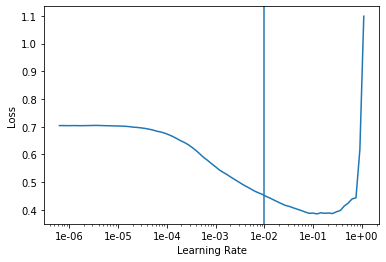

In [11]:
lr = 1e-2
learn.recorder.plot(skip_end=1)
plt.axvline(lr)

In [ ]:
lr = 1e-2/3
flattenAnneal(learn, lr, 20, 0.7)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.105657,0.114329,0.960458,25:17
1,0.091184,0.088737,0.968778,25:04
2,0.084456,0.081064,0.971306,25:21
3,0.079818,0.081883,0.971473,25:27
4,0.078082,0.077912,0.972699,25:26
5,0.075722,0.072903,0.973937,25:23
6,0.073986,0.072040,0.974502,25:25
7,0.073229,0.069622,0.974938,25:26
8,0.069468,0.069623,0.975002,25:23
9,0.068432,0.068785,0.975299,25:23


Better model found at epoch 0 with valid_loss value: 0.114329032599926.
Better model found at epoch 1 with valid_loss value: 0.08873681724071503.
Better model found at epoch 2 with valid_loss value: 0.08106383681297302.
Better model found at epoch 4 with valid_loss value: 0.07791224867105484.
Better model found at epoch 5 with valid_loss value: 0.0729031041264534.
Better model found at epoch 6 with valid_loss value: 0.07203959673643112.
Better model found at epoch 7 with valid_loss value: 0.06962229311466217.
Better model found at epoch 9 with valid_loss value: 0.06878529489040375.
Better model found at epoch 10 with valid_loss value: 0.06823457777500153.
Better model found at epoch 11 with valid_loss value: 0.06726512312889099.
Better model found at epoch 14 with valid_loss value: 0.06646209210157394.
Better model found at epoch 15 with valid_loss value: 0.06528320908546448.
Better model found at epoch 16 with valid_loss value: 0.062432803213596344.
Better model found at epoch 17 with

In [7]:
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [8]:
get_preds(learn)

In [9]:
get_preds(learn, TTA=True)

In [11]:
learn.to_fp32();

In [ ]:
!sudo shutdown